In [1]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# TO DO
# need to figure out how to ger around ema_a > ema_b on second time while rsi check is positive.
# dkng u path nvda arkg pltr ttd sofi ionq tsla googl celh arm rblx hcp ai joby

In [3]:
ticker = 'snow'

In [4]:
# Fetch data for a ticker
df = yf.download(ticker, start='2023-01-01', end='2024-03-02')

[*********************100%%**********************]  1 of 1 completed


In [5]:
# Calculate moving averages 5|7 3|21 5|13
df['EMA_A'] = df['Close'].ewm(span=5, adjust=False).mean()
df['EMA_B'] = df['Close'].ewm(span=7, adjust=False).mean()

In [6]:
# Calculate the RSI
delta = df['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
rsi = 100 - (100 / (1 + rs))

# Define the overbought and oversold levels (typically 70 and 30, respectively)
overbought_level = float(0.0)
oversold_level = float(0.0)

# Compute the median between overbought and oversold levels
median_rsi = np.median([overbought_level, oversold_level])

# Add the Median_RSI column indicating whether RSI is above or below the median
df['Median_RSI'] = np.where(rsi > median_rsi, 'above_median', 'below_median')

# add rsi column with rsi value
df['rsi'] = rsi

# ensure rsi is above median to be used in the crossed_above condition
rsi_check = df['rsi'] > median_rsi

In [7]:
# Calculate MACD and signal line
def calculate_macd(df):
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

df['MACD'], df['Signal'] = calculate_macd(df)

In [8]:
# Identify when the 5-day EMA crosses above the 21-day EMA
# crossed_above = (df['EMA_A'] > df['EMA_B']) & (df['EMA_A'].shift(1) < df['EMA_B'].shift(1)) & (rsi_check)
crossed_above = (df['EMA_A'] > df['EMA_B']) & (df['EMA_A'].shift(1) < df['EMA_B'].shift(1))

In [9]:
# # # Identify when the MACD line crosses below the signal line
# crossed_above = (df['MACD'] > df['Signal']) & (df['MACD'].shift(1) <= df['Signal'].shift(1))

In [10]:
df.loc[crossed_above, 'Cross_Direction'] = 'crossed up'

In [11]:
# Identify when the A-day EMA crosses below the B-Day EMA
crossed_below = (df['EMA_A'] < df['EMA_B']) & (df['EMA_A'].shift(1) > df['EMA_B'].shift(1))
df.loc[crossed_below, 'Cross_Direction'] = 'crossed down'

In [12]:
# # Identify when the A-day EMA crosses below the B-Day EMA
# crossed_below_ema = (df['EMA_A'] < df['EMA_B']) & (df['EMA_A'].shift(1) > df['EMA_B'].shift(1))

# # Identify when the MACD line crosses below the signal line
# crossed_below_macd = (df['MACD'] < df['Signal']) & (df['MACD'].shift(1) > df['Signal'].shift(1))

# # Combine both conditions using logical OR operator
# crossed_below = crossed_below_ema | crossed_below_macd

# # Update the 'Cross_Direction' column
# df.loc[crossed_below, 'Cross_Direction'] = 'crossed down'

In [13]:
# # Identify when the MACD line crosses below the signal line
# crossed_below = (df['MACD'] < df['Signal']) & (df['MACD'].shift(1) > df['Signal'].shift(1))

# # Update the 'Cross_Direction' column
# df.loc[crossed_below, 'Cross_Direction'] = 'crossed down'

In [14]:
# Filter for rows where the 5-day EMA crossed either above or below the 21-day EMA
condition_met = df[df['Cross_Direction'].notna()]

In [15]:
# Display the dates when the conditions were met and the direction of the crossover
print("\nDates when the conditions were met and cross direction:")
condition_met[['Close', 'EMA_A', 'EMA_B', 'Cross_Direction', 'Median_RSI', 'rsi']]


Dates when the conditions were met and cross direction:


,Close,EMA_A,EMA_B,Cross_Direction,Median_RSI,rsi
Date,,,,,,
2023-01-10,137.940002,132.670781,132.430136,crossed up,below_median,NaN
2023-02-17,154.080002,162.489562,162.805460,crossed down,above_median,50.594021
2023-03-23,140.570007,138.552896,138.546136,crossed up,above_median,48.135600
2023-03-24,136.529999,137.878597,138.042101,crossed down,above_median,43.885199
2023-03-30,142.110001,138.454169,138.171408,crossed up,above_median,62.514676
2023-04-11,139.190002,144.720779,144.942101,crossed down,above_median,48.276905
2023-04-18,145.889999,144.183354,144.049718,crossed up,above_median,59.836651
2023-04-20,142.720001,143.777047,143.811092,crossed down,above_median,50.584404
2023-04-21,145.190002,144.248032,144.155820,crossed up,above_median,39.289087


In [17]:
df

,Open,High,Low,Close,Adj Close,Volume,EMA_A,EMA_B,Median_RSI,rsi,MACD,Signal,Cross_Direction
Date,,,,,,,,,,,,,
2023-01-03,146.479996,149.199997,135.339996,135.500000,135.500000,4442000,135.500000,135.500000,below_median,NaN,0.000000,0.000000,NaN
2023-01-04,137.279999,137.600006,128.580002,130.440002,130.440002,6672900,133.813334,134.235001,below_median,NaN,-0.403647,-0.080729,NaN
2023-01-05,129.300003,129.490005,121.040001,121.559998,121.559998,8231800,129.728889,131.066250,below_median,NaN,-1.423670,-0.349318,NaN
2023-01-06,122.089996,126.070000,119.269997,124.059998,124.059998,5827400,127.839258,129.314687,below_median,NaN,-2.007180,-0.680890,NaN
2023-01-09,127.230003,137.639999,126.669998,134.429993,134.429993,8192900,130.036170,130.593513,below_median,NaN,-1.614236,-0.867559,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,229.330002,233.360001,226.649994,230.929993,230.929993,4820600,227.551989,226.950099,above_median,60.923465,7.414899,7.938822,NaN
2024-02-27,233.000000,235.660004,231.089996,234.029999,234.029999,4810300,229.711326,228.720074,above_median,64.260696,7.593898,7.869837,NaN
2024-02-28,230.750000,233.880005,226.559998,230.000000,230.000000,19406200,229.807550,229.040056,above_median,58.308633,7.326118,7.761093,NaN


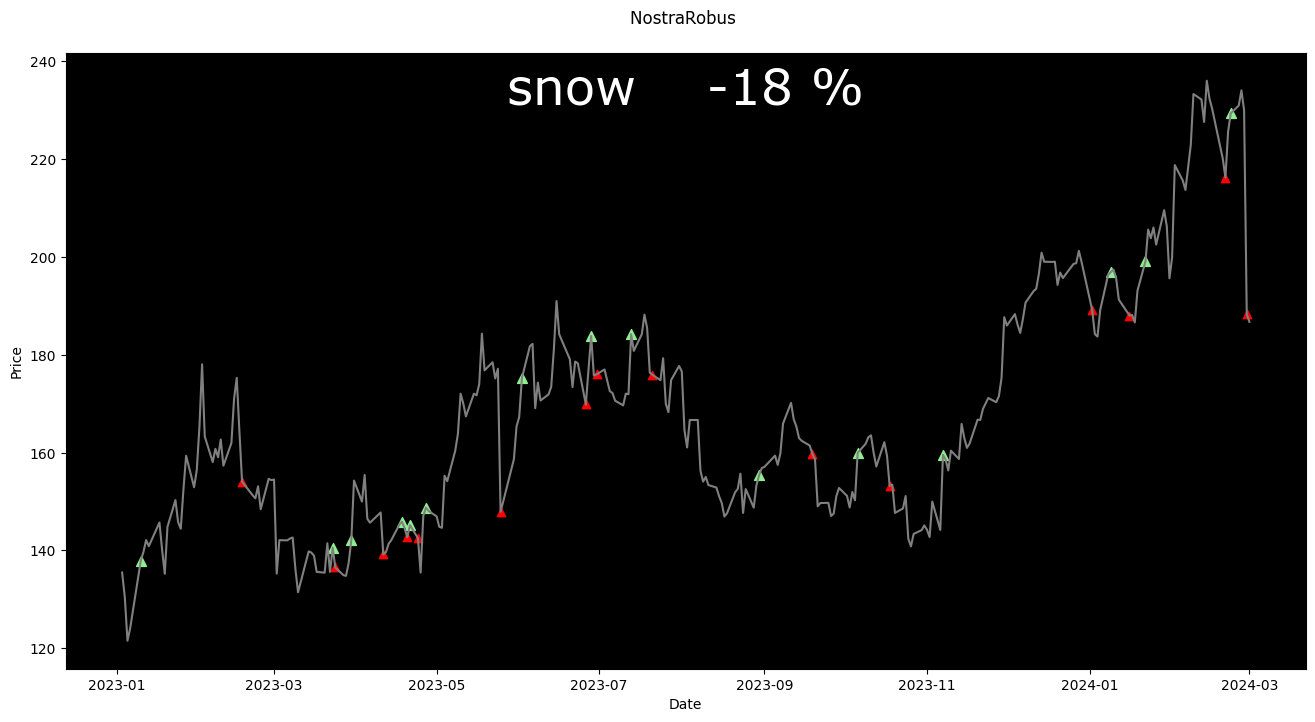

Results For Ticker:   snow
Initial Investment:  137.94000244140625
Final Portfolio Value:  113
Profit/Loss:  -24.7
Percent: -17.9%




,Action,Date,Open,Close,Price,Cash
0,Buy,2023-01-10,134.860001,137.940002,137.940002,0.000000
1,Sell,2023-02-17,160.500000,154.080002,160.500000,154.080002
2,Buy,2023-03-23,137.990005,140.570007,140.570007,13.509995
3,Sell,2023-03-24,139.300003,136.529999,139.300003,150.039993
4,Buy,2023-03-30,139.990005,142.110001,142.110001,7.929993
5,Sell,2023-04-11,139.679993,139.190002,139.679993,147.119995
6,Buy,2023-04-18,147.529999,145.889999,145.889999,1.229996
7,Sell,2023-04-20,142.300003,142.720001,142.300003,143.949997
8,Buy,2023-04-21,144.070007,145.190002,145.190002,-1.240005
9,Sell,2023-04-24,144.850006,142.509995,144.850006,141.269989


In [18]:
# Initialize variables
init_cost = 0
cash = init_cost  # Initial cash balance
shares_owned = 0
portfolio_value = cash
prev_crossed_above = False
rsi_above_median = False
transactions = []
last_trans = 'crossed down'
df.iloc[-1, df.columns.get_loc('Cross_Direction')] = last_trans

# Plot the line graph with arrows indicating the direction of crossover
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['Close'], label='Close Price', color='gray')
plt.gca().set_facecolor('black')  # Set the background color to black



# Find the first crossed up event and set the initial cost
for index, row in df.iterrows():
    if row['Cross_Direction'] == 'crossed up':
        init_cost = row['Close']  # Set init_cost to the price at the first crossed up event
        cash = init_cost  # Set cash to the initial cost
        break

# Loop through the dataframe
for index, row in df.iterrows():
    if row['Cross_Direction'] == 'crossed up' and prev_crossed_above == False:  # Check if the Cross_Direction column is 'crossed up'
        # Buy one share
        # shares_owned += 1
        cash -= row['Close']  # Deduct purchase price from cash
        transactions.append(('Buy', index, row['Open'], row['Close'], row['Close'], cash))
        prev_crossed_above = True
        plt.scatter(index, row['Close'], marker='^', color='lightgreen', s=50, label='Crossed Up')
    elif row['Cross_Direction'] == 'crossed down' and prev_crossed_above:  # Check if the Cross_Direction column is 'crossed down':
        cash += row['Close'] #* shares_owned  # Add sale price to cash
        transactions.append(('Sell', index, row['Open'], row['Close'], row['Open'], cash))
        prev_crossed_above = False
        plt.scatter(index, row['Close'], marker='^', color='red', label='Crossed Down')
    else:
        pass
    
# Calculate final portfolio value
portfolio_value = cash

# Evaluate performance
initial_investment = init_cost # Initial cash investment
profit_loss = portfolio_value - initial_investment
percent = (profit_loss / initial_investment) * 100

# Add the ticker symbol and other things as labels
plt.text(0.5, 0.9, ticker + '    ' + str(round(percent)) + ' %', transform=plt.gca().transAxes, fontsize=36, verticalalignment='bottom', \
         horizontalalignment='center', fontname='MS Reference Sans Serif', fontweight='bold', color='white')
plt.title('NostraRobus \n', fontname='MS Reference Sans Serif', fontweight='bold', color='black')
plt.xlabel('Date', color='black')
plt.ylabel('Price', color='black')
plt.tick_params(axis='x', colors='black')
plt.tick_params(axis='y', colors='black')
plt.grid(False)
plt.show()






print('Results For Ticker:  ', ticker)
print('Initial Investment: ', initial_investment)
print("Final Portfolio Value: ", int(portfolio_value))
print("Profit/Loss: ", round(profit_loss,1))
print("Percent: {:.1f}%".format(percent))
print('\n')
transactions_df = pd.DataFrame(transactions, columns=['Action', 'Date', 'Open', 'Close', 'Price', 'Cash'])
transactions_df



In [19]:
# df.to_csv('filename.csv', index=True)
# transactions_df.to_csv('filename.csv', index=True)


In [20]:
# transactions_df = pd.DataFrame(transactions, columns=['Action', 'Date', 'Open', 'Close', 'Price', 'Cash'])
# transactions_df